<a href="https://colab.research.google.com/github/AdindaRahajengSilviaPranesti/MarchineLearning_2141720158_AdindaRSP_02/blob/main/Week10RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🖥 **Job Sheet 10: RNN**
####- **🌼Adinda Rahajeng Silvia Pranesti🌼**
###- **🌼2141720158 / 02**
###- **🌼3I-TI**

##**🖥LAB WORK 1**
**RNN for Sentiment Analysis**

**Setup**

Import matplotlib and create a helper function to plot the graph:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Setup input pipeline**

The IMDB movie review dataset is a binary classification dataset—all reviews have either positive or negative sentiment.
Download the dataset using TFDS.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# Initially, this returns a dataset (text, label pairs):
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
# Next, shuffle the data for training and create this pair dataset:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This started bad, got worse, and by the time the girl attacked the old lady at the end i literally wanted to take the DVD to the person we borrowed it off and choke the C**T to death with it. Avoid this film, a little bit of good cinematography and some naked shots, would be almost acceptable if i was 14 and had not seen Jenna Jameson naked a million times. If anyone feels the need to watch this film, i would strongly recommend you spend the time more appropriately, as an example i would say trying to cram a Lego house into your bum with no lube would be a good start. I hear that this film was not the original version, i would very much like to view the original, as it seems that this cut version is devoid of all plot, and apparently most of the nudity, can someone please tell me how i can get in touch with Christian Viel he owes me an hour of my life back!'
 b'In light of the recent and quite good Batman the Brave and the Bold, now is the time to bear a fatal blow to that m

**Create a Text Encoder**


Raw text loaded by tfds needs to be processed before it can be used in a model. The easiest way to preprocess text for training is to use the TextVectorization layer. This layer has many capabilities, but in this tutorial, we are using the default behavior. Create this layer and pass the text dataset to the layer's .adapt method:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# After padding and unknown tokens, they are sorted by frequency:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
# The index tensor is padded with 0s to the longest sequence in the batch (unless if you set output_sequence_length fixed):
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 628,  84, ...,   0,   0,   0],
       [  8, 705,   5, ...,   0,   0,   0],
       [  1,   1,   1, ..., 316, 153, 596]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This started bad, got worse, and by the time the girl attacked the old lady at the end i literally wanted to take the DVD to the person we borrowed it off and choke the C**T to death with it. Avoid this film, a little bit of good cinematography and some naked shots, would be almost acceptable if i was 14 and had not seen Jenna Jameson naked a million times. If anyone feels the need to watch this film, i would strongly recommend you spend the time more appropriately, as an example i would say trying to cram a Lego house into your bum with no lube would be a good start. I hear that this film was not the original version, i would very much like to view the original, as it seems that this cut version is devoid of all plot, and apparently most of the nudity, can someone please tell me how i can get in touch with Christian Viel he owes me an hour of my life back!'
Round-trip:  this started bad got worse and by the time the girl [UNK] the old lady at the end i [UNK] wanted to tak

##**Create a Model**

In [10]:
#STEP 1
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
# step 2
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# step 3
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.01290771]


In [13]:
# step 4
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 361ms/step
[0.01290772]


In [14]:
# Compile the Keras model to configure the training process:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##**Train Model**

In [15]:
#step 1
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 655s 2s/step - loss: 0.6739 - accuracy: 0.5318 - val_loss: 0.6439 - val_accuracy: 0.5516
Epoch 2/10
391/391 [==============================] - 645s 2s/step - loss: 0.5359 - accuracy: 0.7381 - val_loss: 0.4731 - val_accuracy: 0.8021
Epoch 3/10
391/391 [==============================] - 624s 2s/step - loss: 0.4532 - accuracy: 0.8132 - val_loss: 0.4268 - val_accuracy: 0.8188
Epoch 4/10
391/391 [==============================] - 643s 2s/step - loss: 0.3959 - accuracy: 0.8330 - val_loss: 0.3947 - val_accuracy: 0.8271
Epoch 5/10
391/391 [==============================] - 644s 2s/step - loss: 0.3600 - accuracy: 0.8439 - val_loss: 0.3644 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 635s 2s/step - loss: 0.3406 - accuracy: 0.8522 - val_loss: 0.3458 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 647s 2s/step - loss: 0.3288 - accuracy: 0.8569 - val_loss: 0.3386 - val_accuracy: 0.8464

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 155s 395ms/step - loss: 0.3212 - accuracy: 0.8622
Test Loss: 0.3211860954761505
Test Accuracy: 0.8621600270271301


(0.0, 0.6921789973974228)

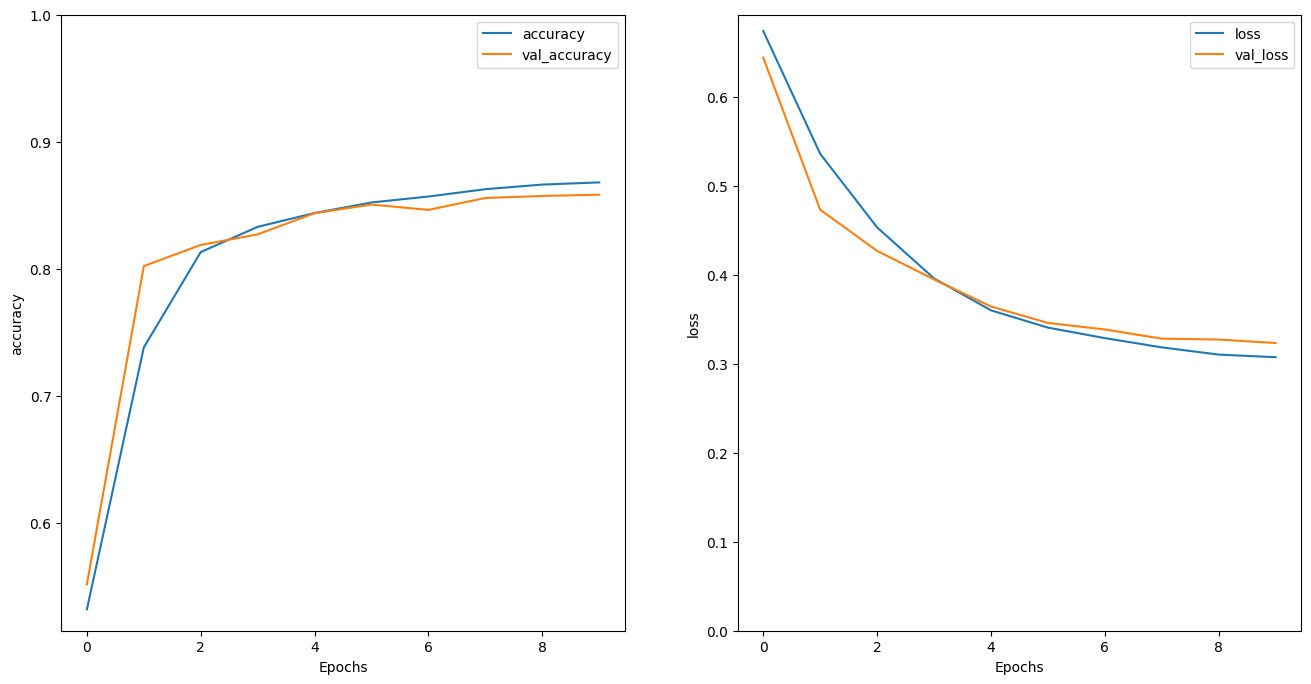

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on a new sentence: If the prediction is >= 0.0, it's positive; otherwise, it's negative.

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


One interesting aspect of using RNNs with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to other RNN layers, like this:

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [3]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

NameError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')